## 1. Setup

### 1.1 Importar Libs

In [1]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import json
import pickle
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, roc_curve)
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint
from joblib import dump, load
import warnings
warnings.filterwarnings('ignore')

# Importar funções dos módulos customizados
from ml_utils import gmean_score, evaluate_model, load_and_prepare_datasets
from search_utils import (plot_search_history, multiple_randomized_search,
                          plot_search_history_from_loaded, 
                          load_search_results, get_best_params_from_saved,
                          save_search_results, save_final_results, DEFAULT_CV_STRATEGY)

# Configurações de plotagem
plt.rcParams['figure.figsize'] = [12, 8]
sns.set_style("whitegrid")

print("Bibliotecas importadas com sucesso!")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")

Bibliotecas importadas com sucesso!
Pandas: 2.3.3
NumPy: 2.3.3
Scikit-learn: 1.7.2


### 1.2 Definir Comitê de Redes Neurais

In [3]:
# ======================================================================
# COMITÊ DE REDES NEURAIS - IMPLEMENTAÇÃO (ESTILO STACKING)
# ======================================================================

from sklearn.base import BaseEstimator, ClassifierMixin

class NeuralNetworkCommittee(BaseEstimator, ClassifierMixin):
    def __init__(self, 
                 # Parâmetros da MLP 1
                 mlp1_hidden_layers=(100,),
                 mlp1_alpha=0.01,
                 mlp1_learning_rate_init=0.001,
                 mlp1_max_iter=200,
                 mlp1_activation='relu',
                 mlp1_learning_rate='constant',
                 
                 # Parâmetros da MLP 2
                 mlp2_hidden_layers=(100, 50),
                 mlp2_alpha=0.01,
                 mlp2_learning_rate_init=0.001,
                 mlp2_max_iter=200,
                 mlp2_activation='tanh',
                 mlp2_learning_rate='adaptive',
                 
                 # Parâmetros da MLP 3
                 mlp3_hidden_layers=(50,),
                 mlp3_alpha=0.01,
                 mlp3_learning_rate_init=0.001,
                 mlp3_max_iter=200,
                 mlp3_activation='logistic',
                 mlp3_learning_rate='constant',
                 
                 # Parâmetros do comitê
                 solver='lbfgs', 
                 voting='soft',
                 random_state=None):
        """
        Comitê de 3 Redes Neurais com parâmetros individuais (estilo Stacking)
        
        Cada rede do comitê tem seus próprios hiperparâmetros otimizados
        independentemente, permitindo configurações heterogêneas.
        
        Parameters:
        -----------
        mlp1_* : diversos
            Hiperparâmetros da primeira rede neural
        mlp2_* : diversos
            Hiperparâmetros da segunda rede neural
        mlp3_* : diversos
            Hiperparâmetros da terceira rede neural
        solver : str
            Algoritmo de otimização (comum a todas)
        voting : str
            Tipo de votação ('hard' ou 'soft')
        random_state : int
            Seed para reprodutibilidade
        """
        # MLP 1
        self.mlp1_hidden_layers = mlp1_hidden_layers
        self.mlp1_alpha = mlp1_alpha
        self.mlp1_learning_rate_init = mlp1_learning_rate_init
        self.mlp1_max_iter = mlp1_max_iter
        self.mlp1_activation = mlp1_activation
        self.mlp1_learning_rate = mlp1_learning_rate
        
        # MLP 2
        self.mlp2_hidden_layers = mlp2_hidden_layers
        self.mlp2_alpha = mlp2_alpha
        self.mlp2_learning_rate_init = mlp2_learning_rate_init
        self.mlp2_max_iter = mlp2_max_iter
        self.mlp2_activation = mlp2_activation
        self.mlp2_learning_rate = mlp2_learning_rate
        
        # MLP 3
        self.mlp3_hidden_layers = mlp3_hidden_layers
        self.mlp3_alpha = mlp3_alpha
        self.mlp3_learning_rate_init = mlp3_learning_rate_init
        self.mlp3_max_iter = mlp3_max_iter
        self.mlp3_activation = mlp3_activation
        self.mlp3_learning_rate = mlp3_learning_rate
        
        # Comitê
        self.solver = solver
        self.voting = voting
        self.random_state = random_state
        
    def fit(self, X, y):
        # Criar as 3 redes neurais com parâmetros individuais
        mlp_1 = MLPClassifier(
            hidden_layer_sizes=self.mlp1_hidden_layers,
            alpha=self.mlp1_alpha,
            learning_rate_init=self.mlp1_learning_rate_init,
            max_iter=self.mlp1_max_iter,
            activation=self.mlp1_activation,
            solver=self.solver,
            random_state=self.random_state,
            early_stopping=True,
            learning_rate=self.mlp1_learning_rate,
            validation_fraction=0.1
        )
        
        mlp_2 = MLPClassifier(
            hidden_layer_sizes=self.mlp2_hidden_layers,
            alpha=self.mlp2_alpha,
            learning_rate_init=self.mlp2_learning_rate_init,
            max_iter=self.mlp2_max_iter,
            activation=self.mlp2_activation,
            solver=self.solver,
            random_state=self.random_state + 1 if self.random_state is not None else None,
            early_stopping=True,
            learning_rate=self.mlp2_learning_rate,
            validation_fraction=0.1
        )
        
        mlp_3 = MLPClassifier(
            hidden_layer_sizes=self.mlp3_hidden_layers,
            alpha=self.mlp3_alpha,
            learning_rate_init=self.mlp3_learning_rate_init,
            max_iter=self.mlp3_max_iter,
            activation=self.mlp3_activation,
            solver=self.solver,
            random_state=self.random_state + 2 if self.random_state is not None else None,
            early_stopping=True,
            learning_rate=self.mlp3_learning_rate,
            validation_fraction=0.1
        )
        
        networks = [
            ('mlp_1', mlp_1),
            ('mlp_2', mlp_2),
            ('mlp_3', mlp_3)
        ]
        
        # Criar o comitê com VotingClassifier
        self.committee = VotingClassifier(
            estimators=networks,
            voting=self.voting,
            n_jobs=-1
        )
        
        # Treinar o comitê
        self.committee.fit(X, y)
        self.classes_ = self.committee.classes_
        
        return self
    
    def predict(self, X):
        return self.committee.predict(X)
    
    def predict_proba(self, X):
        if self.voting == 'soft':
            return self.committee.predict_proba(X)
        else:
            raise AttributeError("predict_proba is not available when voting='hard'")
    
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

print("Comitê de Redes Neurais (estilo Stacking) definido com sucesso!")


Comitê de Redes Neurais (estilo Stacking) definido com sucesso!


### 1.3 Configuração do Modelo

In [ ]:
MODEL_NAME = "Neural_Committee"
MODEL_CLASS = NeuralNetworkCommittee
RANDOM_STATE_MODEL = None
RANDOM_STATE_SAMPLE = 10
N_SEARCHES = 20
N_ITER_PER_SEARCH = 10
SAMPLE_SIZE = 0.01
SEARCHES_FOLDER = 'searches'
RESULTS_FOLDER = 'results'
MODELS_FOLDER = 'models'

## 2. Carregamento e Preparação dos Dados

In [5]:
# Carregamento e preparação inicial dos dados
print("=== CARREGAMENTO DOS DATASETS ===")

# Carregar e preparar datasets usando função do módulo
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, train_data, test_data, scaler = load_and_prepare_datasets()

print(f"Dataset de treino: {train_data.shape}")
print(f"Dataset de teste: {test_data.shape}")
print(f"Features: {X_train_scaled.shape[1]}")

print("\nDistribuição das classes:")
print("Treino:", y_train.value_counts().to_dict())
print("Teste:", y_test.value_counts().to_dict())

print("\nPrimeiras linhas do dataset de treino:")

=== CARREGAMENTO DOS DATASETS ===
Dataset de treino: (72795, 17)
Dataset de teste: (8180, 17)
Features: 16

Distribuição das classes:
Treino: {0.0: 54175, 1.0: 18620}
Teste: {0.0: 5894, 1.0: 2286}

Primeiras linhas do dataset de treino:
Dataset de treino: (72795, 17)
Dataset de teste: (8180, 17)
Features: 16

Distribuição das classes:
Treino: {0.0: 54175, 1.0: 18620}
Teste: {0.0: 5894, 1.0: 2286}

Primeiras linhas do dataset de treino:


In [6]:
train_data.head()

,Hour,HR,O2Sat,Temp,MAP,Resp,BUN,Creatinine,Glucose,Hct,Hgb,WBC,Platelets,Gender,HospAdmTime,ICULOS,SepsisLabel
0,-0.828259,-0.396817,0.890288,-1.189896,0.268219,0.158164,0.391841,0.579093,1.632205,0.855053,0.706987,1.433318,0.068024,-1.140335,0.356849,-0.838308,0.0
1,-0.478847,-0.673800,-1.872530,0.324391,1.492201,-0.386455,-0.161934,-0.113524,-0.304515,1.156973,0.656064,-0.813046,1.079563,-1.140335,0.304841,-0.489607,0.0
2,-0.804965,0.544922,-0.644611,0.450581,1.249928,1.065862,-0.662070,-0.345514,0.976526,1.689773,1.623609,-1.137985,-0.149065,0.876935,0.357194,-0.815061,0.0
3,-0.525435,-0.396817,0.583308,-1.745135,-0.084618,0.702783,0.746309,0.543080,-1.476333,0.002573,-0.311482,-0.705572,-0.116992,0.876935,-0.584873,-0.536101,0.0
4,-0.665200,-1.061575,-0.644611,0.488439,0.387085,-0.567994,0.272113,-2.489717,-0.248842,0.748493,0.808834,-0.088417,0.940833,-1.140335,0.357194,-0.675581,0.0


## 3. Sampling para Busca de Hiperparâmetros

In [7]:
# ======================================================================
# SAMPLING ESTRATIFICADO PARA BUSCA DE HIPERPARÂMETROS
# ======================================================================

print("=== PREPARAÇÃO DE AMOSTRA PARA BUSCA DE HIPERPARÂMETROS ===")

# Amostra estratificada do dataset de treino
_, X_sample, _, y_sample = train_test_split(
    X_train_scaled, y_train, 
    test_size=SAMPLE_SIZE,  
    stratify=y_train,
    random_state=RANDOM_STATE_SAMPLE
)

print(f"Dataset original de treino: {X_train_scaled.shape[0]:,} amostras")
print(f"Amostra para busca de hiperparâmetros: {X_sample.shape[0]:,} amostras")
print(f"Redução: {(1 - X_sample.shape[0]/X_train_scaled.shape[0])*100:.1f}%")

print("\nDistribuição das classes na amostra:")
print("Amostra:", pd.Series(y_sample).value_counts().to_dict())
print("Original:", y_train.value_counts().to_dict())

=== PREPARAÇÃO DE AMOSTRA PARA BUSCA DE HIPERPARÂMETROS ===
Dataset original de treino: 72,795 amostras
Amostra para busca de hiperparâmetros: 728 amostras
Redução: 99.0%

Distribuição das classes na amostra:
Amostra: {0.0: 542, 1.0: 186}
Original: {0.0: 54175, 1.0: 18620}


## 4. Definir Estratégia de Validação Cruzada

In [8]:
# Usar estratégia de CV padrão dos módulos
cv_strategy = DEFAULT_CV_STRATEGY
print(f"Estratégia de CV: {cv_strategy}")

Estratégia de CV: StratifiedKFold(n_splits=5, random_state=42, shuffle=True)


## 5. Neural Committee - Busca de Hiperparâmetros

### 5.1 Definir Espaço de Hiperparâmetros

In [ ]:
# ======================================================================
# DEFINIÇÃO DO ESPAÇO DE HIPERPARÂMETROS - NEURAL COMMITTEE (ESTILO STACKING)
# ======================================================================

print(f"=== DEFINIÇÃO DO ESPAÇO DE HIPERPARÂMETROS - {MODEL_NAME} ===")

# Opções de arquiteturas possíveis - ESPAÇO COMPARTILHADO
hidden_layers_list = [
    # 1 camada (shallow networks)
    (25,), (50,), (75,), (100,), (150,), (200,),
    
    # 2 camadas (medium networks)
    (50, 25), (100, 50), (150, 75), (200, 100), (100, 100), (150, 150),
    (100, 25), (200, 50), (50, 50), (25, 200), (25, 25), (50, 200),
    (150, 50), (100, 150), (150, 25), (50, 100), (75, 50), 

    # 3 camadas (deeper networks)
    (100, 50, 25), (100, 100, 50), (50, 50, 50),
    (25, 25, 25), (50, 25, 25), (25, 50, 25), (25, 25, 50),
    (100, 75, 50), (75, 75, 75), (50, 100, 50),
    (100, 100, 100), (200, 200, 200), (100, 50, 200), (200, 300, 100),

    (200, 200, 200, 200), (100, 100, 100, 100),
    (50, 100, 200, 300), (300, 200, 100, 50), 
    (50, 50, 50, 50), (100, 100, 50, 50),
    (100, 50, 100, 50), 
]

# Espaços compartilhados para todas as redes
alpha_values = uniform(0.01, 0.1)  # uniform(loc=min, scale=max-min)
learning_rate_init_values = uniform(0.01, 0.1)
max_iter_values = randint(100, 500)  
activation_options = ['relu', 'tanh', 'logistic']
learning_rate_options = ['constant', 'adaptive', 'invscaling']

# ======================================================================
# PARAM_DISTRIBUTIONS - PARÂMETROS INDIVIDUAIS PARA CADA REDE (3 REDES FIXAS)
# ======================================================================

param_distributions = {
    # === MLP 1 ===
    'mlp1_hidden_layers': hidden_layers_list,
    'mlp1_alpha': alpha_values,
    'mlp1_learning_rate_init': learning_rate_init_values,
    'mlp1_max_iter': max_iter_values,
    'mlp1_activation': activation_options,
    'mlp1_learning_rate': learning_rate_options,
    
    # === MLP 2 ===
    'mlp2_hidden_layers': hidden_layers_list,
    'mlp2_alpha': alpha_values,
    'mlp2_learning_rate_init': learning_rate_init_values,
    'mlp2_max_iter': max_iter_values,
    'mlp2_activation': activation_options,
    'mlp2_learning_rate': learning_rate_options,
    
    # === MLP 3 ===
    'mlp3_hidden_layers': hidden_layers_list,
    'mlp3_alpha': alpha_values,
    'mlp3_learning_rate_init': learning_rate_init_values,
    'mlp3_max_iter': max_iter_values,
    'mlp3_activation': activation_options,
    'mlp3_learning_rate': learning_rate_options,
}

print("\n=== ESPAÇO DE HIPERPARÂMETROS DEFINIDO ===")
print(f"Comitê com 3 redes fixas (MLP 1, MLP 2, MLP 3)")
print(f"Arquiteturas: {len(hidden_layers_list)} opções")


=== DEFINIÇÃO DO ESPAÇO DE HIPERPARÂMETROS - Neural_Committee ===

=== ESPAÇO DE HIPERPARÂMETROS DEFINIDO ===
Comitê com 3 redes fixas (MLP 1, MLP 2, MLP 3)
Arquiteturas: 33 opções


### 5.2 Executar Busca de Hiperparâmetros

In [12]:
# ======================================================================
# BUSCA DE HIPERPARAMETROS
# ======================================================================

print(f"=== BUSCA DE HIPERPARÂMETROS - {MODEL_NAME} ===")
print(f"Iniciando busca de hiperparâmetros para {MODEL_NAME}...")
print(f"Executando {N_SEARCHES} buscas com {N_ITER_PER_SEARCH} iterações cada...")
print(f"Usando amostra de {X_sample.shape[0]:,} exemplos\n")

# Múltiplas execuções do RandomizedSearchCV
search, all_searches, best_params = multiple_randomized_search(
    estimator=NeuralNetworkCommittee(random_state=RANDOM_STATE_MODEL, 
                                     solver='lbfgs', # lbfgs demonstrou melhor desempenho geral, então foi fixado para as NN mais fracas
                                     voting='soft'), # voting 'soft' para probabilidades 
    param_distributions=param_distributions,
    X=X_sample,
    y=y_sample,
    cv_strategy=cv_strategy,
    n_searches=N_SEARCHES,
    n_iter_per_search=N_ITER_PER_SEARCH,
    scoring='f1',
    random_state=None,
    n_jobs=1
)

# Exibir os melhores resultados
print(f"\n--- RESULTADOS {MODEL_NAME} ---")
print("Melhores hiperparâmetros encontrados:")
for param, value in best_params.items():
    if 'options' in param or 'range' in param:
        print(f"  {param}: {value if len(str(value)) < 50 else str(value)[:50] + '...'}")
    else:
        print(f"  {param}: {value}")
print(f"\nMelhor F1-Score (CV): {search.best_score_:.4f}")
print(f"Desvio padrão: {search.cv_results_['std_test_score'][search.best_index_]:.4f}")

=== BUSCA DE HIPERPARÂMETROS - Neural_Committee ===
Iniciando busca de hiperparâmetros para Neural_Committee...
Executando 20 buscas com 5 iterações cada...
Usando amostra de 728 exemplos

Executando 20 buscas com 5 iterações cada...

Busca 1/20...
Melhor score desta busca: 0.4646
Melhor configuração desta busca: {'mlp1_activation': 'logistic', 'mlp1_alpha': np.float64(0.0804412448386035), 'mlp1_hidden_layers': (200, 100), 'mlp1_learning_rate': 'invscaling', 'mlp1_learning_rate_init': np.float64(0.03418645955622193), 'mlp1_max_iter': 480, 'mlp2_activation': 'relu', 'mlp2_alpha': np.float64(0.0279971427660932), 'mlp2_hidden_layers': (25, 200), 'mlp2_learning_rate': 'constant', 'mlp2_learning_rate_init': np.float64(0.09586942889726789), 'mlp2_max_iter': 123, 'mlp3_activation': 'logistic', 'mlp3_alpha': np.float64(0.025162150649071048), 'mlp3_hidden_layers': (50, 200), 'mlp3_learning_rate': 'adaptive', 'mlp3_learning_rate_init': np.float64(0.01170535960157594), 'mlp3_max_iter': 345}
Melho

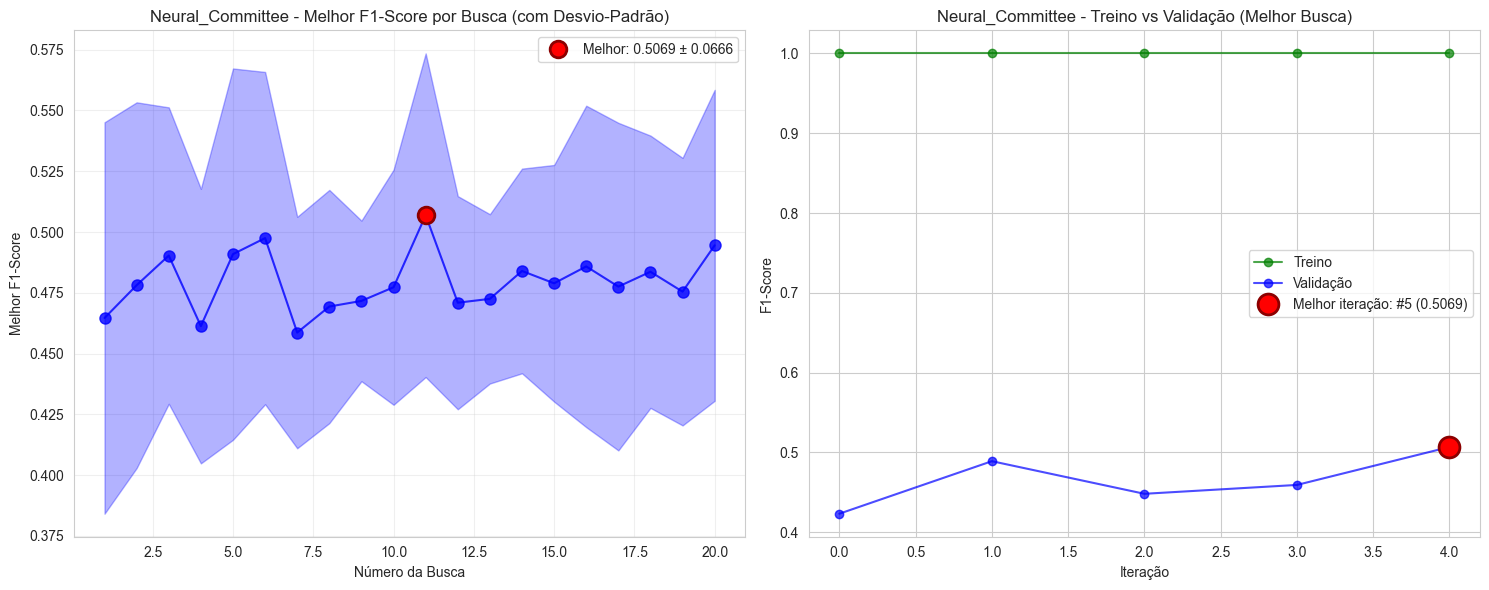

In [14]:
# Registro de Desempenho - plotar evolução da busca
plot_search_history(all_searches, search, MODEL_NAME)

### 5.3 Visualizar Histórico da Busca

In [13]:
# ======================================================================
# ANÁLISE DAS MELHORES CONFIGURAÇÕES ENCONTRADAS
# ======================================================================

print(f"=== MELHORES CONFIGURAÇÕES ENCONTRADAS POR BUSCA - {MODEL_NAME} ===")

# Extrair os melhores resultados de cada busca
best_configs = []

for i, search_result in enumerate(all_searches):
    config = {
        'Busca': i + 1,
        'F1_Score': search_result['best_score'],
        **search_result['best_params']
    }
    best_configs.append(config)

# Criar DataFrame e exibir top configs
results_df = pd.DataFrame(best_configs)
results_df = results_df.sort_values('F1_Score', ascending=False).round(4)

print(f"\nTop configurações (de {len(results_df)} buscas):")
print(results_df.to_string(index=False))

print(f"\nEstatísticas dos F1-Scores encontrados:")
print(f"  Média: {results_df['F1_Score'].mean():.4f}")
print(f"  Mediana: {results_df['F1_Score'].median():.4f}")
print(f"  Desvio padrão: {results_df['F1_Score'].std():.4f}")
print(f"  Min: {results_df['F1_Score'].min():.4f}")
print(f"  Max: {results_df['F1_Score'].max():.4f}")

=== MELHORES CONFIGURAÇÕES ENCONTRADAS POR BUSCA - Neural_Committee ===

Top configurações (de 20 buscas):
 Busca  F1_Score mlp1_activation  mlp1_alpha mlp1_hidden_layers mlp1_learning_rate  mlp1_learning_rate_init  mlp1_max_iter mlp2_activation  mlp2_alpha mlp2_hidden_layers mlp2_learning_rate  mlp2_learning_rate_init  mlp2_max_iter mlp3_activation  mlp3_alpha mlp3_hidden_layers mlp3_learning_rate  mlp3_learning_rate_init  mlp3_max_iter
    11    0.5069            tanh      0.0259     (100, 100, 50)         invscaling                   0.0665            132        logistic      0.1003              (25,)         invscaling                   0.0195            102        logistic      0.0800           (50, 25)         invscaling                   0.0487            101
     6    0.4975            tanh      0.0687           (75, 50)         invscaling                   0.0278            416        logistic      0.0406          (100, 50)           constant                   0.0647          

In [15]:
# ======================================================================
# ANÁLISE DAS CONFIGURAÇÕES INDIVIDUAIS DE CADA REDE NOS MELHORES COMITÊS
# ======================================================================

print(f"=== CONFIGURAÇÕES INDIVIDUAIS DAS REDES - TOP 5 COMITÊS ===\n")

top_n = min(5, len(all_searches))

# Ordenar buscas por score
sorted_searches = sorted(enumerate(all_searches), 
                        key=lambda x: x[1]['best_score'], 
                        reverse=True)

for rank, (search_idx, search_result) in enumerate(sorted_searches[:top_n], 1):
    params = search_result['best_params']
    score = search_result['best_score']
    
    print("=" * 140)
    print(f"🏆 RANK #{rank} - Busca {search_idx + 1} | F1-Score: {score:.4f}")
    print("=" * 140)
    
    # Exibir configuração de cada rede
    for mlp_num in [1, 2, 3]:
        print(f"\n🔹 MLP {mlp_num}:")
        
        arch_key = f'mlp{mlp_num}_hidden_layers'
        alpha_key = f'mlp{mlp_num}_alpha'
        lr_init_key = f'mlp{mlp_num}_learning_rate_init'
        max_iter_key = f'mlp{mlp_num}_max_iter'
        activation_key = f'mlp{mlp_num}_activation'
        lr_strategy_key = f'mlp{mlp_num}_learning_rate'
        
        arch = params.get(arch_key, 'N/A')
        alpha = params.get(alpha_key, 'N/A')
        lr_init = params.get(lr_init_key, 'N/A')
        max_iter = params.get(max_iter_key, 'N/A')
        activation = params.get(activation_key, 'N/A')
        lr_strategy = params.get(lr_strategy_key, 'N/A')
        
        print(f"   Arquitetura: {arch}")
        print(f"   Alpha: {alpha if isinstance(alpha, str) else f'{alpha:.6f}'}")
        print(f"   Learning Rate Init: {lr_init if isinstance(lr_init, str) else f'{lr_init:.6f}'}")
        print(f"   Max Iterations: {max_iter}")
        print(f"   Activation: {activation}")
        print(f"   Learning Rate Strategy: {lr_strategy}")
    
    # Análise de diversidade
    architectures = [params.get(f'mlp{i}_hidden_layers') for i in [1, 2, 3]]
    activations = [params.get(f'mlp{i}_activation') for i in [1, 2, 3]]
    lr_strategies = [params.get(f'mlp{i}_learning_rate') for i in [1, 2, 3]]
    
    unique_arch = len(set(architectures))
    unique_act = len(set(activations))
    unique_lr = len(set(lr_strategies))
    
    # Classificar redes por complexidade
    shallow = sum(1 for arch in architectures if arch and len(arch) == 1)
    medium = sum(1 for arch in architectures if arch and len(arch) == 2)
    deep = sum(1 for arch in architectures if arch and len(arch) >= 3)
    
    print(f"\n📊 DIVERSIDADE DO COMITÊ:")
    print(f"   • Arquiteturas únicas: {unique_arch}/3")
    print(f"   • Ativações únicas: {unique_act}/3")
    print(f"   • LR Strategies únicas: {unique_lr}/3")
    print(f"   • Distribuição: {shallow} shallow | {medium} medium | {deep} deep")
    print()

print("=" * 140)
print(f"✅ Análise de configurações individuais concluída!")


=== CONFIGURAÇÕES INDIVIDUAIS DAS REDES - TOP 5 COMITÊS ===

🏆 RANK #1 - Busca 11 | F1-Score: 0.5069

🔹 MLP 1:
   Arquitetura: (100, 100, 50)
   Alpha: 0.025920
   Learning Rate Init: 0.066539
   Max Iterations: 132
   Activation: tanh
   Learning Rate Strategy: invscaling

🔹 MLP 2:
   Arquitetura: (25,)
   Alpha: 0.100268
   Learning Rate Init: 0.019465
   Max Iterations: 102
   Activation: logistic
   Learning Rate Strategy: invscaling

🔹 MLP 3:
   Arquitetura: (50, 25)
   Alpha: 0.080024
   Learning Rate Init: 0.048696
   Max Iterations: 101
   Activation: logistic
   Learning Rate Strategy: invscaling

📊 DIVERSIDADE DO COMITÊ:
   • Arquiteturas únicas: 3/3
   • Ativações únicas: 2/3
   • LR Strategies únicas: 1/3
   • Distribuição: 1 shallow | 1 medium | 1 deep

🏆 RANK #2 - Busca 6 | F1-Score: 0.4975

🔹 MLP 1:
   Arquitetura: (75, 50)
   Alpha: 0.068695
   Learning Rate Init: 0.027785
   Max Iterations: 416
   Activation: tanh
   Learning Rate Strategy: invscaling

🔹 MLP 2:
   Arqu

## 6. Salvar Resultados de Busca

In [19]:
search_df = save_search_results(
    model_name=MODEL_NAME,
    model_search=search,
    model_all_searches=all_searches,
    n_searches=N_SEARCHES,
    n_iter_per_search=N_ITER_PER_SEARCH,
    scoring='f1',
    cv_folds=cv_strategy.get_n_splits(),
    top_params_columns=param_distributions.keys(),
    searches_folder=SEARCHES_FOLDER
)

=== SALVANDO RESULTADOS DA BUSCA - NEURAL_COMMITTEE ===
  ✅ Todos os Resultados salvos: searches\neural_committee_all_searches.csv
  Total de configurações testadas: 100
  ✅ Resumo salvo: searches\neural_committee_search_summary.json

--- ESTATÍSTICAS DA BUSCA NEURAL_COMMITTEE ---
Melhor F1-Score: 0.5069
Desvio padrão do melhor: 0.0666
F1-Score médio geral: 0.4579
F1-Score mínimo: 0.4190
F1-Score máximo: 0.5069


### 6.2 Carregar Resultado de Busca (Opcional)

In [20]:
loaded_results = load_search_results(MODEL_NAME)

=== CARREGANDO RESULTADOS DE BUSCA - NEURAL_COMMITTEE ===
✅ Resultados detalhados carregados: 100 configurações
✅ Resumo carregado: F1-Score = 0.5069
⚠️  Arquivo não encontrado: searches\neural_committee_full_search.pkl


In [ ]:
# Plotar a história da busca a partir dos resultados carregados
plot_search_history_from_loaded(loaded_results, MODEL_NAME)

### 6.3 Definir Melhores Params e CV score

In [23]:
# Definir Melhores Parâmetros para Uso Posterior
if 'loaded_results' in locals() and 'search' not in locals():
    best_params = get_best_params_from_saved(MODEL_NAME)
    best_score = loaded_results['summary']['best_overall_score']
    print(f"✅ Usando parâmetros carregados: {best_params}")
    print(f"✅ Melhor F1-Score carregado: {best_score:.4f}")
else:
    best_params = search.best_params_
    best_score = search.best_score_
    print(f"✅ Usando parâmetros da busca atual: {best_params}")
    print(f"✅ Melhor F1-Score da busca atual: {best_score:.4f}")

✅ Usando parâmetros da busca atual: {'mlp1_activation': 'tanh', 'mlp1_alpha': np.float64(0.02592019138503914), 'mlp1_hidden_layers': (100, 100, 50), 'mlp1_learning_rate': 'invscaling', 'mlp1_learning_rate_init': np.float64(0.06653897508582422), 'mlp1_max_iter': 132, 'mlp2_activation': 'logistic', 'mlp2_alpha': np.float64(0.10026811564098388), 'mlp2_hidden_layers': (25,), 'mlp2_learning_rate': 'invscaling', 'mlp2_learning_rate_init': np.float64(0.019464791851500476), 'mlp2_max_iter': 102, 'mlp3_activation': 'logistic', 'mlp3_alpha': np.float64(0.08002392311877701), 'mlp3_hidden_layers': (50, 25), 'mlp3_learning_rate': 'invscaling', 'mlp3_learning_rate_init': np.float64(0.04869628940897574), 'mlp3_max_iter': 101}
✅ Melhor F1-Score da busca atual: 0.5069


## 7. Treinar Modelo Final e Salvar

In [27]:
# Treinamento Final com melhores hiperparâmetros


best_model = NeuralNetworkCommittee(**best_params)
best_model.fit(X_train_scaled, y_train)
print(f"\nModelo final {MODEL_NAME} treinado com dataset completo: {best_model}")


Modelo final Neural_Committee treinado com dataset completo: NeuralNetworkCommittee(mlp1_activation='tanh',
                       mlp1_alpha=np.float64(0.02592019138503914),
                       mlp1_hidden_layers=(100, 100, 50),
                       mlp1_learning_rate='invscaling',
                       mlp1_learning_rate_init=np.float64(0.06653897508582422),
                       mlp1_max_iter=132, mlp2_activation='logistic',
                       mlp2_alpha=np.float64(0.10026811564098388),
                       mlp2_hidden_layers=(25,),
                       mlp2_learning_rate='invscaling',
                       mlp2_learning_rate_init=np.float64(0.019464791851500476),
                       mlp2_max_iter=102,
                       mlp3_alpha=np.float64(0.08002392311877701),
                       mlp3_hidden_layers=(50, 25),
                       mlp3_learning_rate='invscaling',
                       mlp3_learning_rate_init=np.float64(0.04869628940897574),
          

In [31]:
# Save the trained model immediately after training
os.makedirs(MODELS_FOLDER, exist_ok=True)

model_path = os.path.join(MODELS_FOLDER, f'{MODEL_NAME.lower().replace(" ", "_")}_model.joblib')
dump(best_model, model_path)
print(f"✅ Model saved to: {model_path}")

✅ Model saved to: models\neural_committee_model.joblib


## 8. Avaliação Final e Salvamento dos Resultados

In [ ]:
# Carregar modelo (Opcional)
loaded_model = load(os.path.join(MODELS_FOLDER, f'{MODEL_NAME.lower().replace(" ", "_")}_model.joblib'))

In [28]:
print(f"=== AVALIAÇÃO E SALVAMENTO DOS RESULTADOS - {MODEL_NAME} ===")

# Criar pastas se não existirem
os.makedirs(RESULTS_FOLDER, exist_ok=True)

# Avaliação completa do modelo
print("\nAvaliando performance do modelo...")

if 'loaded_model' in locals():
    model = loaded_model
else:
    model = best_model

# Usar datasets completos para avaliação final
X_train_eval = X_train_scaled
y_train_eval = y_train
X_test_eval = X_test_scaled
y_test_eval = y_test

# Avaliar modelo usando função do módulo
train_metrics, test_metrics, y_test_pred = evaluate_model(
    best_model, X_train_eval, X_test_eval, y_train_eval, y_test_eval, MODEL_NAME
)

=== AVALIAÇÃO E SALVAMENTO DOS RESULTADOS - Neural_Committee ===

Avaliando performance do modelo...


### 8.1 Classification Report

In [29]:
print(classification_report(y_test_eval, y_test_pred, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.83      0.92      0.87      5894
         1.0       0.70      0.50      0.58      2286

    accuracy                           0.80      8180
   macro avg       0.76      0.71      0.73      8180
weighted avg       0.79      0.80      0.79      8180



### 8.2 Visualize Confusion Matrix

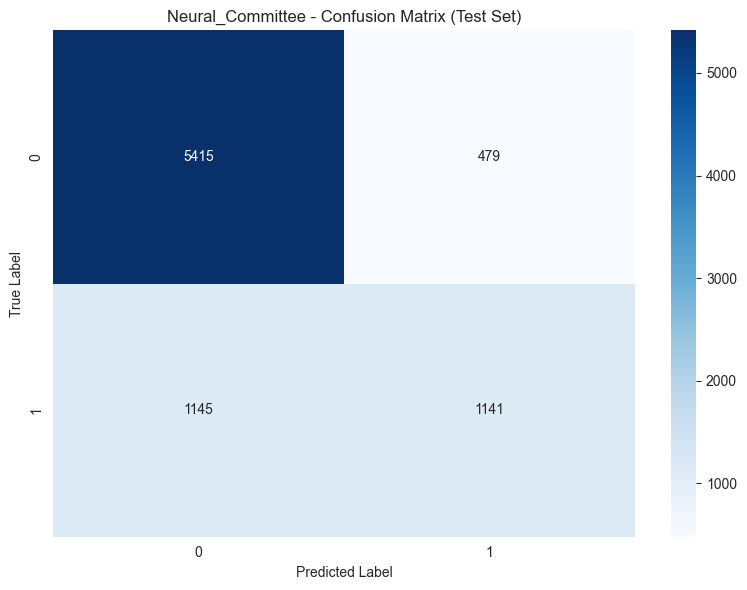

In [30]:
# Plot confusion matrix
cm = confusion_matrix(y_test_eval, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title(f'{MODEL_NAME} - Confusion Matrix (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 8.3 Save Final Results

In [33]:
# Salvar resultados finais usando função do módulo
model_final_results = save_final_results(
    model_name=MODEL_NAME,
    best_params=best_params,
    best_score=best_score,
    train_metrics=train_metrics,
    test_metrics=test_metrics,
    y_pred=y_test_pred,
    y_test=y_test_eval,
    X_train_scaled=X_train_eval,
    X_test_scaled=X_test_eval,
    results_folder=RESULTS_FOLDER
)

# Mostrar resumo final
print(f"\n--- RESUMO FINAL {MODEL_NAME} ---")
print(f"F1-Score CV: {model_final_results['best_cv_score']:.4f}")
print(f"F1-Score Teste: {test_metrics['f1']:.4f}")
print(f"Acurácia Teste: {test_metrics['accuracy']:.4f}")
print(f"Precisão Teste: {test_metrics['precision']:.4f}")
print(f"Recall Teste: {test_metrics['recall']:.4f}")
print(f"G-Mean Teste: {test_metrics['gmean']:.4f}")
if test_metrics.get('auc_roc'):
    print(f"AUC-ROC Teste: {test_metrics['auc_roc']:.4f}")

print(f"\nHistórico de busca salvo em: {SEARCHES_FOLDER}/")
print(f"Modelo salvo em: {MODELS_FOLDER}/")
print(f"Resultados salvos em: {RESULTS_FOLDER}/")
print(f"\nAvaliação do {MODEL_NAME} concluída com sucesso!")

✅ Resultados Neural_Committee salvos em: results\neural_committee_results.json

--- RESUMO FINAL Neural_Committee ---
F1-Score CV: 0.5069
F1-Score Teste: 0.5842
Acurácia Teste: 0.8015
Precisão Teste: 0.7043
Recall Teste: 0.4991
G-Mean Teste: 0.6772
AUC-ROC Teste: 0.8234

Histórico de busca salvo em: searches/
Modelo salvo em: models/
Resultados salvos em: results/

Avaliação do Neural_Committee concluída com sucesso!
